**XGBoost**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, RocCurveDisplay
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessed Using custom stopwords created during EDA part

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/scraped_headlines.csv")
df["title"] = df["title"].str.strip().str.lower()

In [ ]:
with open("/content/drive/MyDrive/custom_stopwords.txt", "r") as f:
    custom_stopwords = [line.strip() for line in f.readlines()]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['title'], df['label'], test_size=0.3, random_state=42, stratify=df['label'])

# Performing Gridsearch CV

In [ ]:
from xgboost import XGBClassifier

In [37]:
vectorizers = {
    "TF-IDF": TfidfVectorizer(stop_words=custom_stopwords),
    "Count": CountVectorizer(stop_words=custom_stopwords),
    "Hashing": HashingVectorizer(stop_words='english', n_features=5000)
}

results = {}

xgb_model = XGBClassifier()


===== Running GridSearch for TF-IDF Vectorizer =====
Fitting 3 folds for each of 256 candidates, totalling 768 fits
Best Params for TF-IDF: {'vectorizer__max_features': 4000, 'vectorizer__ngram_range': (1, 1), 'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}
Test Accuracy: 0.7138
ROC AUC: 0.7942

              precision    recall  f1-score   support

           0       0.67      0.83      0.74       743
           1       0.78      0.60      0.68       749

    accuracy                           0.71      1492
   macro avg       0.73      0.71      0.71      1492
weighted avg       0.73      0.71      0.71      1492



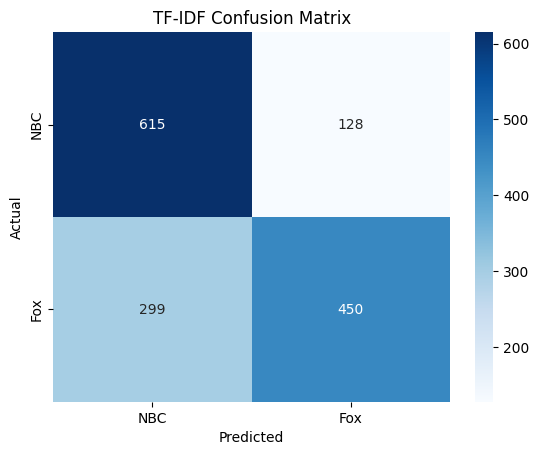

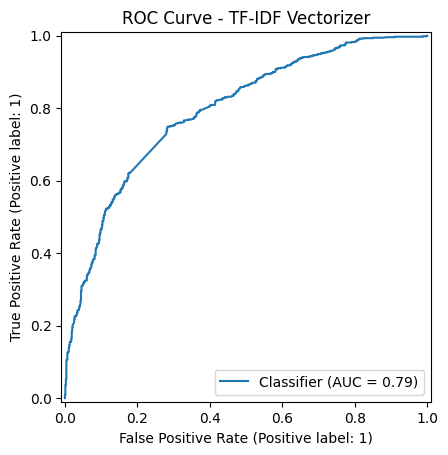


Examples of Misclassified Headlines:
3224    harris seeks to recapture obama-era energy as ...
610     hurricane chaser in florida says milton prompt...
4184    several federal agencies launch a 'deferred re...
2119        taylor swift endorses joe biden for president
1169    iran fires multiple missile strikes across israel
361     sinwar's removal from battlefield is ‘signific...
3432    appeals court rejects mark meadows’ bid to mov...
4541    trump emergency declaration cites eye-popping ...
3881    suspect in fatal stabbing during frisco high s...
1736    kirby slams hamas chief sinwar as 'the major o...
Name: title, dtype: object

===== Running GridSearch for Count Vectorizer =====
Fitting 3 folds for each of 256 candidates, totalling 768 fits
Best Params for Count: {'vectorizer__max_features': 4000, 'vectorizer__ngram_range': (1, 2), 'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 200, 'xgb__subsample': 1.0}
Test Accuracy: 0.72

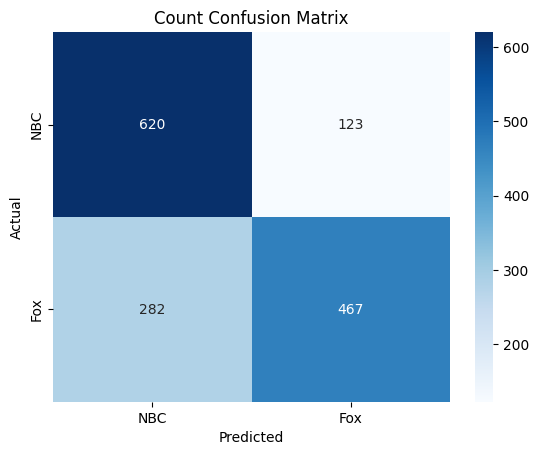

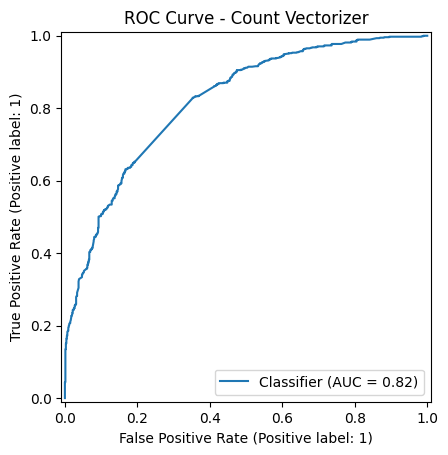


Examples of Misclassified Headlines:
4370    new york state bans deepseek from government d...
3224    harris seeks to recapture obama-era energy as ...
610     hurricane chaser in florida says milton prompt...
2119        taylor swift endorses joe biden for president
1169    iran fires multiple missile strikes across israel
2033    after false pet claims, springfield mayor says...
361     sinwar's removal from battlefield is ‘signific...
4541    trump emergency declaration cites eye-popping ...
3881    suspect in fatal stabbing during frisco high s...
1736    kirby slams hamas chief sinwar as 'the major o...
Name: title, dtype: object

===== Running GridSearch for Hashing Vectorizer =====
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Params for Hashing: {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}
Test Accuracy: 0.7105
ROC AUC: 0.7968

              precision    recall  f1-score   s

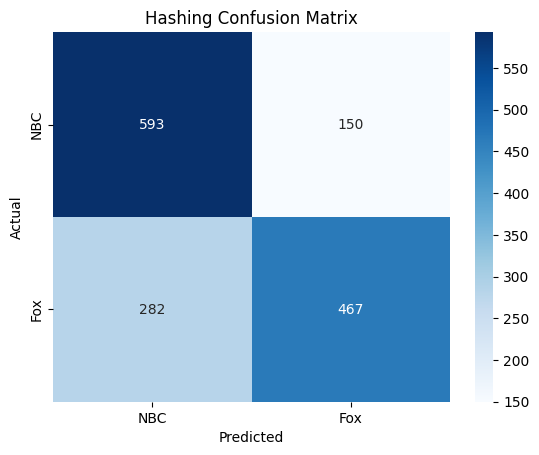

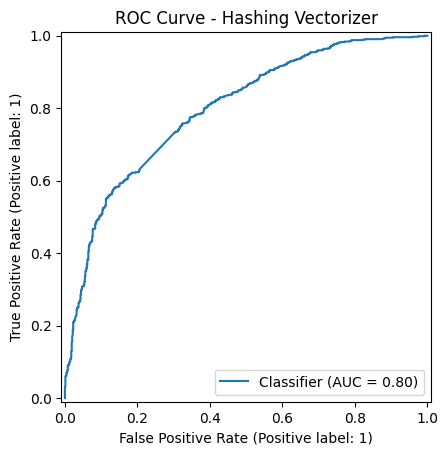


Examples of Misclassified Headlines:
3224    harris seeks to recapture obama-era energy as ...
610     hurricane chaser in florida says milton prompt...
1169    iran fires multiple missile strikes across israel
2033    after false pet claims, springfield mayor says...
1901    black group fires back at obama for ‘insulting...
752     children of missing korean war airman hold us ...
3881    suspect in fatal stabbing during frisco high s...
1736    kirby slams hamas chief sinwar as 'the major o...
4831    'blindsided': how stefanik's trump nomination ...
258     wwe legend hulk hogan has super bowl aspiratio...
Name: title, dtype: object


In [38]:
for name, vectorizer in vectorizers.items():
    print(f"\n===== Running GridSearch for {name} Vectorizer =====")

    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('xgb', xgb_model)
    ])

    if name == "TF-IDF":
        param_grid = {
            'vectorizer__max_features': [2000, 3000, 4000, 5000],
            'vectorizer__ngram_range': [(1, 1), (1, 2)],
            'xgb__n_estimators': [100, 200],
            'xgb__max_depth': [3, 5],
            'xgb__learning_rate': [0.05, 0.1],
            'xgb__subsample': [0.8, 1.0],
            'xgb__colsample_bytree': [0.8, 1.0]
        }
    elif name == "Count":
        param_grid = {
            'vectorizer__max_features': [2000, 3000, 4000, 5000],
            'vectorizer__ngram_range': [(1, 1), (1, 2)],
            'xgb__n_estimators': [100, 200],
            'xgb__max_depth': [3, 5],
            'xgb__learning_rate': [0.05, 0.1],
            'xgb__subsample': [0.8, 1.0],
            'xgb__colsample_bytree': [0.8, 1.0]
        }
    elif name == "Hashing":
        param_grid = {
            'xgb__n_estimators': [100, 200],
            'xgb__max_depth': [3, 5],
            'xgb__learning_rate': [0.05, 0.1],
            'xgb__subsample': [0.8, 1.0],
            'xgb__colsample_bytree': [0.8, 1.0]
        }

    grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
    grid.fit(x_train, y_train)

    y_pred = grid.predict(x_test)
    y_proba = grid.predict_proba(x_test)[:, 1]

    print(f"Best Params for {name}: {grid.best_params_}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}\n")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NBC', 'Fox'], yticklabels=['NBC', 'Fox'])
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f'ROC Curve - {name} Vectorizer')
    plt.show()

    misclassified = x_test[y_test != y_pred]
    print("\nExamples of Misclassified Headlines:")
    print(misclassified.head(10))

    results[name] = {
        'model': grid.best_estimator_,
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'params': grid.best_params_
    }

In [ ]:
xgb_model = XGBClassifier(
    eval_metric='logloss',
    learning_rate=0.1,
    max_depth=5,
    colsample_bytree=0.8
)

vec = CountVectorizer(stop_words=custom_stopwords, max_features=3000, ngram_range=(1, 2))
X = vec.fit_transform(df['title'])

xgb_model.fit(X, df['label'])


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
df2 = pd.read_csv("/content/drive/MyDrive/news_testData_randomSubset.csv")
df2["title"] = df2["title"].str.strip().str.lower()

In [ ]:
X = vec.transform(df2['title'])

y_pred = xgb_model.predict(X)

# Evaluate performance
accuracy = accuracy_score(df2['labels'], y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7500


# Testing the model on the Test Data Provided on 1 May

In [ ]:
unseen_df = pd.read_csv("/content/drive/MyDrive/News Classification_Test Data_Project.csv")

unseen_df["clean_title"] = unseen_df["Headline"].str.strip().str.lower()

X = vec.transform(unseen_df["clean_title"])

In [ ]:
preds_num = xgb_model.predict(X)

unseen_df["Label(FoxNews/NBC)"] = ["FoxNews" if p == 1 else "NBC" for p in preds_num]

In [ ]:
unseen_df[["ID","Headline","Label(FoxNews/NBC)"]].to_csv(
    "/content/drive/MyDrive/XGB_predictions.csv",
    index=False
)

In [ ]:
print(unseen_df["Label(FoxNews/NBC)"].value_counts())

Label(FoxNews/NBC)
NBC        761
FoxNews    412
Name: count, dtype: int64
